In [1]:
import os

from shapely.geometry import Polygon

os.environ["USE_PYGEOS"] = "0"
import os
import shutil

import geopandas
import napari
import numpy as np
import spatialdata as sd
from napari_spatialdata import Interactive
from spatialdata.transformations import (
    Affine,
    Identity,
    Sequence,
    align_elements_using_landmarks,
    get_transformation,
    set_transformation,
)

/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("current working directory:", os.getcwd())
SPATIALDATA_SANDBOX_PATH = "spatialdata-sandbox"
assert os.path.isdir(
    SPATIALDATA_SANDBOX_PATH
), f"{SPATIALDATA_SANDBOX_PATH} not found, please use symlinks to make it available"
GENERATED_DATA_PATH = os.path.join(SPATIALDATA_SANDBOX_PATH, "generated_data/xenium_visium_integration")
assert os.path.isdir(GENERATED_DATA_PATH), f"{GENERATED_DATA_PATH} not found, please use symlinks to make it available"


XE_REP1_PATH = os.path.join(SPATIALDATA_SANDBOX_PATH, "xenium_rep1_io/data_aligned.zarr")
XE_REP2_PATH = os.path.join(SPATIALDATA_SANDBOX_PATH, "xenium_rep2_io/data_aligned.zarr")
VISIUM_PATH = os.path.join(SPATIALDATA_SANDBOX_PATH, "visium_associated_xenium_io/data_aligned.zarr")
# XE_REP1_PATH = os.path.join(SPATIALDATA_SANDBOX_PATH, "xenium_rep1_io/data.zarr")
# XE_REP2_PATH = os.path.join(SPATIALDATA_SANDBOX_PATH, "xenium_rep2_io/data.zarr")
# VISIUM_PATH = os.path.join(
#     SPATIALDATA_SANDBOX_PATH, "visium_associated_xenium_io/data.zarr"
# )
assert os.path.isdir(XE_REP1_PATH), XE_REP1_PATH
assert os.path.isdir(XE_REP2_PATH), XE_REP2_PATH
assert os.path.isdir(VISIUM_PATH), VISIUM_PATH

XE_REP1_ROI_PATH = os.path.join(GENERATED_DATA_PATH, "xe_rep1_roi.zarr")
XE_REP2_ROI_PATH = os.path.join(GENERATED_DATA_PATH, "xe_rep2_roi.zarr")
VISIUM_ROI_PATH = os.path.join(GENERATED_DATA_PATH, "visium_roi.zarr")

LANDMARKS_SDATA_PATH = os.path.join(GENERATED_DATA_PATH, "sandbox.zarr")

current working directory: /Users/macbook/embl/projects/basel/spatialdata-notebooks/notebooks/paper_reproducibility


In [3]:
# we delete some elements (in-memory only) because we will not need them in napari
xe_rep1_sdata = sd.read_zarr(XE_REP1_PATH)
del xe_rep1_sdata.images["morphology_focus"]
del xe_rep1_sdata.shapes["cell_boundaries"]
del xe_rep1_sdata.shapes["nucleus_boundaries"]
xe_rep2_sdata = sd.read_zarr(XE_REP2_PATH)
del xe_rep2_sdata.images["morphology_focus"]
del xe_rep2_sdata.shapes["cell_boundaries"]
del xe_rep2_sdata.shapes["nucleus_boundaries"]
visium_sdata = sd.read_zarr(VISIUM_PATH)

xe_rep1_roi_sdata = sd.read_zarr(XE_REP1_ROI_PATH)
# del xe_rep1_roi_sdata.shapes["cell_boundaries"]
del xe_rep1_roi_sdata.shapes["nucleus_boundaries"]
xe_rep2_roi_sdata = sd.read_zarr(XE_REP2_ROI_PATH)
# del xe_rep2_roi_sdata.shapes["cell_boundaries"]
del xe_rep2_roi_sdata.shapes["nucleus_boundaries"]
visium_roi_sdata = sd.read_zarr(VISIUM_ROI_PATH)

landmarks_sdata = sd.read_zarr(LANDMARKS_SDATA_PATH)

In [4]:
landmarks_sdata["rois"]["name"] = [
    "Invasive",
    "Immune infiltration",
    "DCIS",
    "Duct ectasia",
]
# the new extra column gets not saved to Zarr, we need to discuss this behavior (and the relationships with multiple tables) in the next hackathon
landmarks_sdata["rois"]

geometry                 name
0  POLYGON ((1928.166 9124.230, 1928.166 9151.215...             Invasive
1  POLYGON ((8109.926 14163.968, 8109.926 14173.7...  Immune infiltration
2  POLYGON ((32042.805 22387.401, 32026.302 22436...                 DCIS
3  POLYGON ((27504.676 20232.314, 27514.049 20237...         Duct ectasia

In [5]:
# remove the cells, for xenium rep 2, inside the box (so already present in xenium rep 1)
xe_rep2_sdata.shapes["cell_circles"] = xe_rep2_sdata["cell_circles"][
    ~xe_rep2_sdata["cell_circles"].index.isin(xe_rep2_roi_sdata["cell_circles"].index)
]

In [6]:
from anndata import AnnData


def set_colors_for_categorical_obs(adata: AnnData, column: str, colors_dict: dict[str, str]):
    colors = []
    for cat in adata.obs[column].cat.categories.tolist():
        color = colors_dict[cat]
        colors.append(color)
    adata.uns[f"{column}_colors"] = colors


celltype_major_colors = {
    "B-cells": "#d8f55e",
    "CAFs": "#532C8A",
    "Cancer Epithelial": "#C72228",
    "Endothelial": "#9e6762",
    "Myeloid": "#ffe012",
    "T-cells": "#3cb44b",
    "Normal Epithelial": "#0F4A9C",
    "PVL": "#c09d9a",
    "Plasmablasts": "#000075",
}
set_colors_for_categorical_obs(
    adata=xe_rep1_sdata.table,
    column="celltype_major",
    colors_dict=celltype_major_colors,
)
set_colors_for_categorical_obs(
    adata=xe_rep2_sdata.table,
    column="celltype_major",
    colors_dict=celltype_major_colors,
)

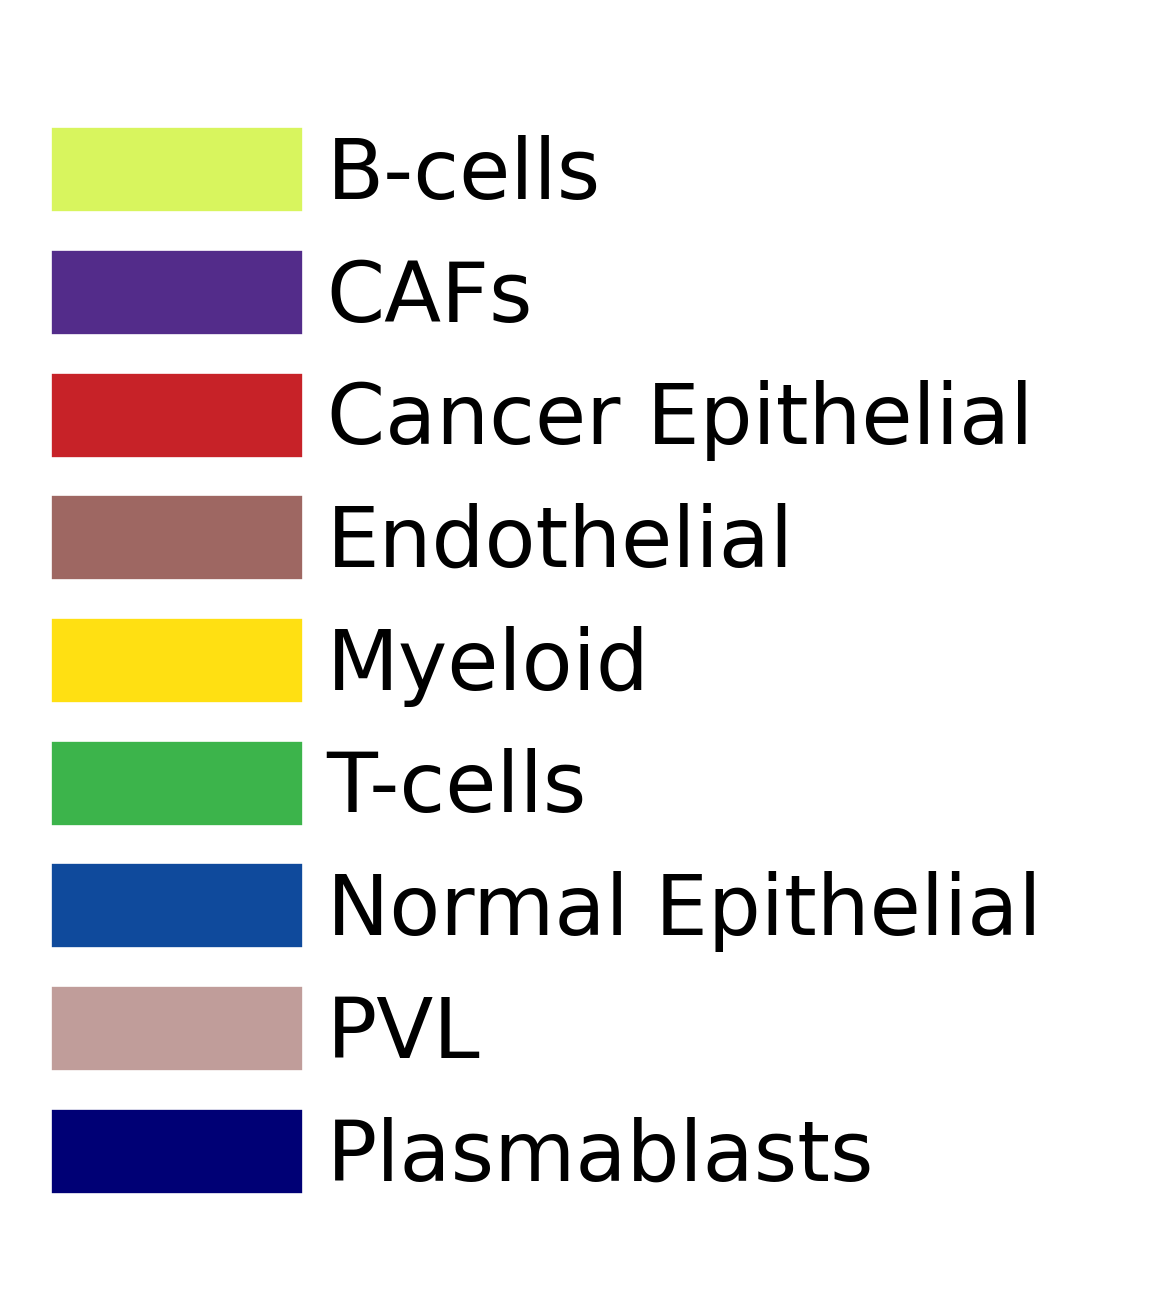

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(2, 1), dpi=600)

for label, color in celltype_major_colors.items():
    ax.plot([], [], label=label, color=color, linestyle="-", linewidth=10)

ax.legend(loc="best", frameon=False)
ax.axis("off")
plt.show()

In [8]:
xe_rep1_roi_sdata.table.obs["celltype_major"] = xe_rep1_roi_sdata.table.obs["celltype_major"].astype("category")
xe_rep1_roi_sdata.table.obs["celltype_minor"] = xe_rep1_roi_sdata.table.obs["celltype_minor"].astype("category")
xe_rep2_roi_sdata.table.obs["celltype_major"] = xe_rep2_roi_sdata.table.obs["celltype_major"].astype("category")
xe_rep2_roi_sdata.table.obs["celltype_minor"] = xe_rep2_roi_sdata.table.obs["celltype_minor"].astype("category")

set_colors_for_categorical_obs(
    adata=xe_rep1_roi_sdata.table,
    column="celltype_major",
    colors_dict=celltype_major_colors,
)
set_colors_for_categorical_obs(
    adata=xe_rep2_roi_sdata.table,
    column="celltype_major",
    colors_dict=celltype_major_colors,
)

In [9]:
clone_colors = {
    "1": "#DA1F26",
    "2": "#3C8F35",
    "3": "#7BB0DF",
    "diploid": "#00000000",
    "not detected": "#00000000",
    # "diploid": "#1966B0",
    # "not detected": "#892F73",
}

set_colors_for_categorical_obs(
    adata=visium_sdata.table,
    column="clone",
    colors_dict=clone_colors,
)

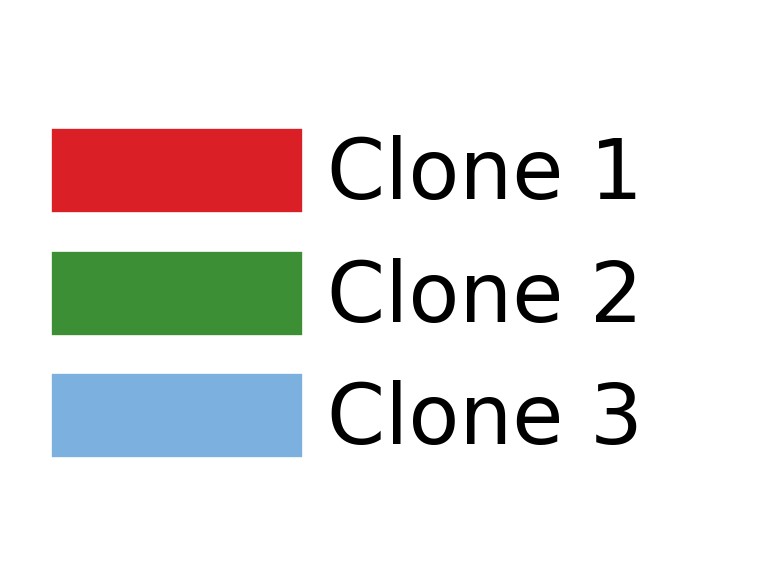

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(1, 1), dpi=600)

for label, color in {f"Clone {k}": v for k, v in clone_colors.items() if k in ["1", "2", "3"]}.items():
    ax.plot([], [], label=label, color=color, linestyle="-", linewidth=10)

ax.legend(loc="best", frameon=False)
ax.axis("off")
plt.show()

In [199]:
Interactive([xe_rep1_sdata, xe_rep2_sdata, visium_sdata, landmarks_sdata], points=False)
# Interactive([xe_rep1_sdata, xe_rep2_sdata, visium_sdata, landmarks_sdata])
# Interactive([xe_rep1_roi_sdata, xe_rep2_roi_sdata, visium_roi_sdata, landmarks_sdata])
# Interactive([xe_rep1_roi_sdata, xe_rep2_roi_sdata, visium_roi_sdata, landmarks_sdata])
# Interactive([xe_rep1_roi_sdata])
# Interactive([visium_sdata, landmarks_sdata])

2023-04-25 17:13:22.076 | WARNING  | napari_spatialdata.interactive:_add_circles:259 - Too many shapes 167780 > 10000, using points instead of ellipses. Size will stop being correct beyond a certain zoom level
2023-04-25 17:13:23.413 | WARNING  | napari_spatialdata.interactive:_add_circles:259 - Too many shapes 19117 > 10000, using points instead of ellipses. Size will stop being correct beyond a certain zoom level
2023-04-25 17:15:58.328 | INFO     | napari_spatialdata._view:_on_layer_update:142 - Updating layer.
2023-04-25 17:16:02.575 | INFO     | napari_spatialdata._view:_on_layer_update:142 - Updating layer.


---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
File ~/miniconda3/envs/ome/lib/python3.10/site-packages/napari/utils/action_manager.py:228, in ActionManager.bind_button.<locals>.<lambda>()
    220     if isgeneratorfunction(action):
    221         raise ValueError(
    222             trans._(
    223                 '`bind_button` cannot be used with generator functions',
    224                 deferred=True,
    225             )
    226         )
--> 228 button.clicked.connect(lambda: self.trigger(name))
        name = 'napari:activate_shape_pan_zoom_mode'
        self = <napari.utils.action_manager.ActionManager object at 0x1f77c7310>
    229 if name in self._actions:
    230     button.setToolTip(
    231         f'{self._build_tooltip(name)} {extra_tooltip_text}'
    232     )

File ~/miniconda3/envs/ome/lib/python3.10/site-packages/napari/utils/action_manager.py:428, in Acti

2023-04-25 17:17:00.344 python[3215:21382807] +[CATransaction synchronize] called within transaction
2023-04-25 17:17:29.826 python[3215:21382807] +[CATransaction synchronize] called within transaction
2023-04-25 17:18:34.403 python[3215:21382807] +[CATransaction synchronize] called within transaction
2023-04-25 17:18:52.968 | INFO     | napari_spatialdata._view:_on_layer_update:142 - Updating layer.
2023-04-25 17:18:56.172 | INFO     | napari_spatialdata._view:_on_layer_update:142 - Updating layer.
2023-04-25 17:20:18.487 python[3215:21382807] +[CATransaction synchronize] called within transaction
2023-04-25 17:20:27.811 | INFO     | napari_spatialdata._view:_on_layer_update:142 - Updating layer.
2023-04-25 17:20:29.117 | INFO     | napari_spatialdata._view:_on_layer_update:142 - Updating layer.
2023-04-25 17:20:30.589 | INFO     | napari_spatialdata._view:_on_layer_update:142 - Updating layer.
2023-04-25 17:20:38.519 | INFO     | napari_spatialdata._view:_on_layer_update:142 - Updati

In [11]:
from shapely import Polygon
from spatialdata import SpatialData
from spatialdata.models import ShapesModel


# same function of notebooks 00, move to a .py file, later on include a reworked version in spatialdata
def spatial_query_shapes_by_polygon(sdata: SpatialData, polygon: Polygon, target_coordinate_system: str):
    new_shapes = {}
    for shapes_name, shapes in sdata.shapes.items():
        if "__old_index" in shapes.columns:
            assert np.all(shapes["__old_index"] == shapes.index)
        else:
            shapes["__old_index"] = shapes.index
        # indices = shapes.intersects(polygon)
        # indices = shapes.geometry.apply(lambda x: x.intersects(polygon).values.tolist()[0][0])
        indices = shapes.geometry.apply(lambda x: x.intersects(polygon))
        if np.sum(indices) == 0:
            continue
        queried_shapes = shapes[indices]
        queried_shapes.index = queried_shapes["__old_index"]
        del shapes["__old_index"]
        del queried_shapes["__old_index"]
        transformation = get_transformation(shapes, target_coordinate_system)
        queried_shapes = ShapesModel.parse(queried_shapes)
        set_transformation(queried_shapes, transformation, target_coordinate_system)
        new_shapes[shapes_name] = queried_shapes
    if len(new_shapes) == 0:
        raise ValueError("we expect at least one shape")
    return SpatialData(shapes=new_shapes, table=sdata.table)

In [12]:
import pandas as pd
from geopandas import GeoDataFrame
from spatialdata.models import TableModel


def get_shapes_in_rois_sdata(
    sdata: SpatialData, shapes_name: str, rois: GeoDataFrame, instance_key: str
) -> SpatialData:
    sdatas = []

    for roi in rois.iterrows():
        geometry, name = roi[1]
        sdata_queried = spatial_query_shapes_by_polygon(
            SpatialData(shapes={shapes_name: sdata[shapes_name]}),
            geometry,
            "aligned",
        )
        region_name = f"Shapes in ROI {name!r}"
        merged = pd.merge(
            sdata.table.obs[[instance_key]],
            sdata_queried.shapes[shapes_name],
            how="right",
            left_on=instance_key,
            right_index=True,
        )
        filtered_table = sdata.table[merged.index].copy()
        filtered_table.obs["region"] = region_name
        del filtered_table.uns["spatialdata_attrs"]
        TableModel.parse(filtered_table, region=region_name, region_key="region", instance_key=instance_key)

        sdata_queried = SpatialData(shapes={region_name: sdata_queried[shapes_name]}, table=filtered_table)
        sdatas.append(sdata_queried)

    cells_in_rois_sdata = sd.concatenate(sdatas)
    return cells_in_rois_sdata

In [13]:
import pandas as pd
from spatialdata.models import TableModel

cells_in_rois_sdata_rep1 = get_shapes_in_rois_sdata(
    sdata=xe_rep1_roi_sdata, shapes_name="cell_circles", rois=landmarks_sdata["rois"], instance_key="cell_id"
)

cells_in_rois_sdata_rep1.table.obs["celltype_major"] = cells_in_rois_sdata_rep1.table.obs["celltype_major"].astype(
    "category"
)
set_colors_for_categorical_obs(
    adata=cells_in_rois_sdata_rep1.table,
    column="celltype_major",
    colors_dict=celltype_major_colors,
)

/tmp/ipykernel_3215/532282607.py:26: UserWarning: Converting `region_key: region` to categorical dtype.
  TableModel.parse(filtered_table, region=region_name, region_key="region", instance_key=instance_key)
/tmp/ipykernel_3215/532282607.py:26: UserWarning: Converting `region_key: region` to categorical dtype.
  TableModel.parse(filtered_table, region=region_name, region_key="region", instance_key=instance_key)
/tmp/ipykernel_3215/532282607.py:26: UserWarning: Converting `region_key: region` to categorical dtype.
  TableModel.parse(filtered_table, region=region_name, region_key="region", instance_key=instance_key)
/tmp/ipykernel_3215/532282607.py:26: UserWarning: Converting `region_key: region` to categorical dtype.
  TableModel.parse(filtered_table, region=region_name, region_key="region", instance_key=instance_key)


In [14]:
cells_in_rois_sdata_rep2 = get_shapes_in_rois_sdata(
    sdata=xe_rep2_roi_sdata, shapes_name="cell_circles", rois=landmarks_sdata["rois"], instance_key="cell_id"
)

cells_in_rois_sdata_rep2.table.obs["celltype_major"] = cells_in_rois_sdata_rep2.table.obs["celltype_major"].astype(
    "category"
)
set_colors_for_categorical_obs(
    adata=cells_in_rois_sdata_rep2.table,
    column="celltype_major",
    colors_dict=celltype_major_colors,
)

/tmp/ipykernel_3215/532282607.py:26: UserWarning: Converting `region_key: region` to categorical dtype.
  TableModel.parse(filtered_table, region=region_name, region_key="region", instance_key=instance_key)
/tmp/ipykernel_3215/532282607.py:26: UserWarning: Converting `region_key: region` to categorical dtype.
  TableModel.parse(filtered_table, region=region_name, region_key="region", instance_key=instance_key)
/tmp/ipykernel_3215/532282607.py:26: UserWarning: Converting `region_key: region` to categorical dtype.
  TableModel.parse(filtered_table, region=region_name, region_key="region", instance_key=instance_key)
/tmp/ipykernel_3215/532282607.py:26: UserWarning: Converting `region_key: region` to categorical dtype.
  TableModel.parse(filtered_table, region=region_name, region_key="region", instance_key=instance_key)


In [15]:
cells_in_rois_sdata_visium = get_shapes_in_rois_sdata(
    sdata=visium_roi_sdata,
    shapes_name="CytAssist_FFPE_Human_Breast_Cancer",
    rois=landmarks_sdata["rois"],
    instance_key="spot_id",
)

# cells_in_rois_sdata_visium.table.obs["celltype_major"] = cells_in_rois_sdata_rep2.table.obs["celltype_major"].astype("category")
# set_colors_for_categorical_obs(
#     adata=cells_in_rois_sdata_rep2.table,
#     column="celltype_major",
#     colors_dict=celltype_major_colors,
# )

/tmp/ipykernel_3215/532282607.py:26: UserWarning: Converting `region_key: region` to categorical dtype.
  TableModel.parse(filtered_table, region=region_name, region_key="region", instance_key=instance_key)
/tmp/ipykernel_3215/532282607.py:26: UserWarning: Converting `region_key: region` to categorical dtype.
  TableModel.parse(filtered_table, region=region_name, region_key="region", instance_key=instance_key)
/tmp/ipykernel_3215/532282607.py:26: UserWarning: Converting `region_key: region` to categorical dtype.
  TableModel.parse(filtered_table, region=region_name, region_key="region", instance_key=instance_key)
/tmp/ipykernel_3215/532282607.py:26: UserWarning: Converting `region_key: region` to categorical dtype.
  TableModel.parse(filtered_table, region=region_name, region_key="region", instance_key=instance_key)


In [16]:
visium_sdata

SpatialData object with:
├── Images
│     ├── 'CytAssist_FFPE_Human_Breast_Cancer_full_image': MultiscaleSpatialImage[cyx] (3, 21571, 19505), (3, 10785, 9752), (3, 5392, 4876), (3, 2696, 2438), (3, 1348, 1219)
│     ├── 'CytAssist_FFPE_Human_Breast_Cancer_hires_image': SpatialImage[cyx] (3, 2000, 1809)
│     └── 'CytAssist_FFPE_Human_Breast_Cancer_lowres_image': SpatialImage[cyx] (3, 600, 543)
├── Shapes
│     └── 'CytAssist_FFPE_Human_Breast_Cancer': GeoDataFrame shape: (4992, 2) (2D shapes)
└── Table
      └── AnnData object with n_obs × n_vars = 4992 × 18085
    obs: 'in_tissue', 'array_row', 'array_col', 'spot_id', 'region', 'dataset', 'clone'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'clone_colors', 'region_colors', 'spatial', 'spatialdata_attrs'
    obsm: 'spatial': AnnData (4992, 18085)
with coordinate systems:
▸ 'aligned', with elements:
        CytAssist_FFPE_Human_Breast_Cancer_full_image (Images), CytAssist_FFPE_Human_Breast_Cancer (Shapes)
▸ 'downscaled_hires'

In [17]:
# rois colors (this is the order how the ROIs are saved)
rois_colors = {
    "Invasive": "#4cb1ff",
    "Immune infiltration": "#7dc573",
    "Duct ectasia": "#ffd700",
    "DCIS": "#ff5500",
}

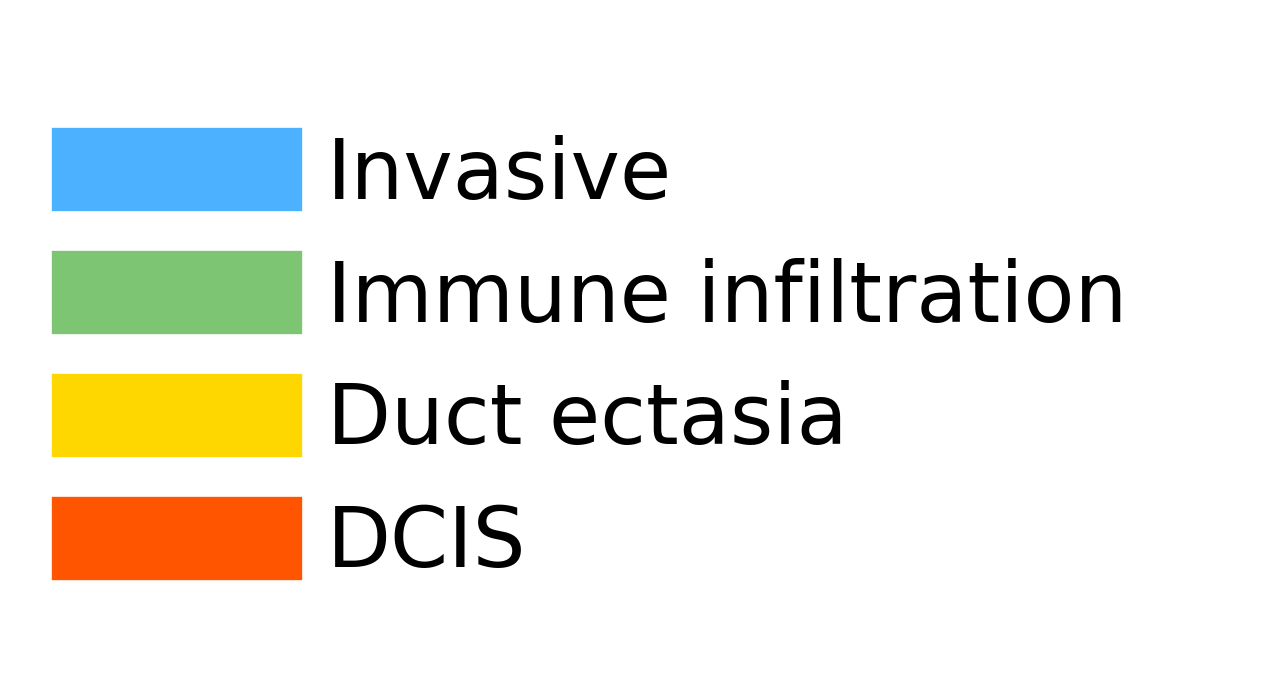

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(2, 1), dpi=600)

for label, color in rois_colors.items():
    ax.plot([], [], label=label, color=color, linestyle="-", linewidth=10)

ax.legend(loc="best", frameon=False)
ax.axis("off")
plt.show()

In [201]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr


def compute_correlations(X1, X2, axis=1):
    correlations = []
    for i in range(X1.shape[axis]):
        if axis == 1:
            row_correlation1, _ = pearsonr(X1[:, i], X2[:, i])
        elif axis == 0:
            row_correlation1, _ = pearsonr(X1[i, :], X2[i, :])
        correlations.append(row_correlation1)
    return np.array(correlations)

In [202]:
visium_roi_sdata

SpatialData object with:
├── Shapes
│     └── 'CytAssist_FFPE_Human_Breast_Cancer': GeoDataFrame shape: (2775, 2) (2D shapes)
└── Table
      └── AnnData object with n_obs × n_vars = 2775 × 307
    obs: 'in_tissue', 'array_row', 'array_col', 'spot_id', 'region', 'dataset', 'clone'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'clone_colors', 'region_colors', 'spatial', 'spatialdata_attrs'
    obsm: 'spatial', 'xe_rep1_celltype_major', 'xe_rep1_celltype_minor', 'xe_rep2_celltype_major', 'xe_rep2_celltype_minor'
    layers: 'xe_rep1_cells', 'xe_rep1_tx', 'xe_rep2_cells', 'xe_rep2_tx', 'visium', 'xe_rep1_tx_log', 'xe_rep2_tx_log': AnnData (2775, 307)
with coordinate systems:
▸ 'aligned', with elements:
        CytAssist_FFPE_Human_Breast_Cancer (Shapes)

/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


[0.7044977331735605, 0.9656610038035054, 0.6966931560345353, nan, 0.6987426496337013, 0.9663718911585085, nan, 0.7055323825909872, nan, nan]


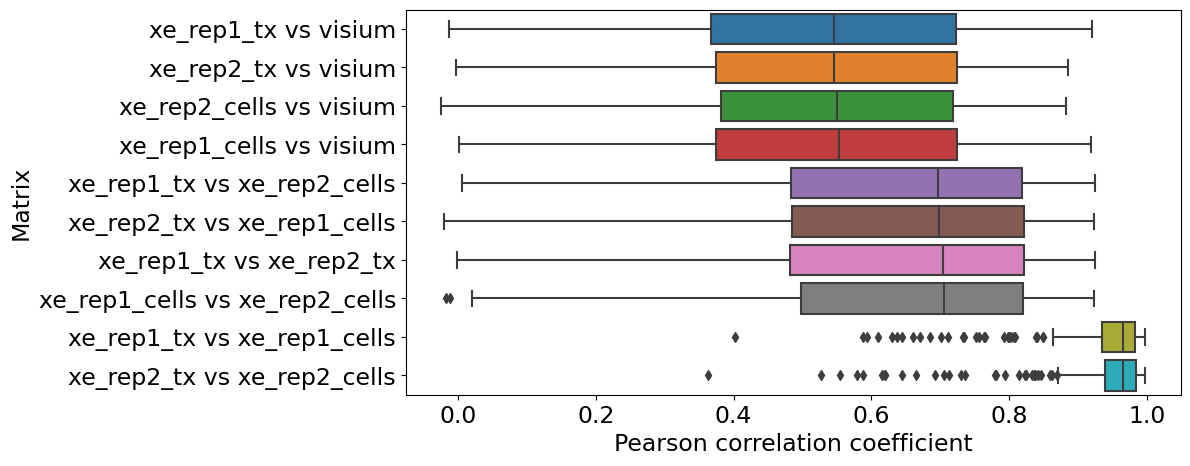

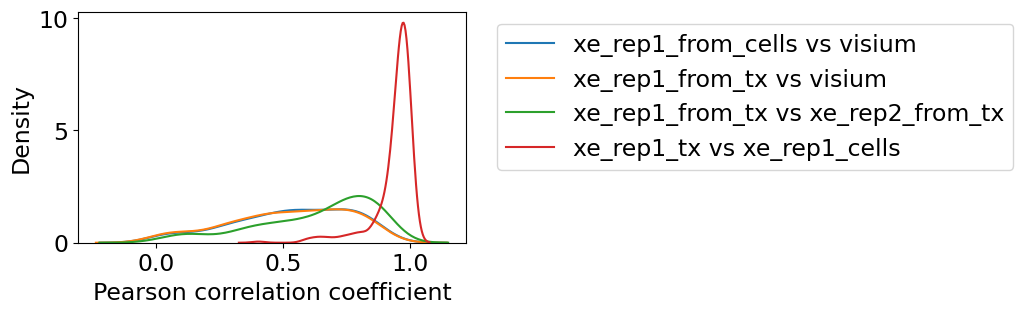

In [200]:
matrices = {
    "xe_rep1_tx": visium_roi_sdata.table.layers["xe_rep1_tx"],
    "xe_rep2_tx": visium_roi_sdata.table.layers["xe_rep2_tx"],
    "xe_rep1_cells": visium_roi_sdata.table.layers["xe_rep1_cells"],
    "xe_rep2_cells": visium_roi_sdata.table.layers["xe_rep2_cells"],
    "visium": visium_roi_sdata.table.X.toarray(),
}
correlations = {}
for i1, (name1, X1) in enumerate(matrices.items()):
    for i2, (name2, X2) in enumerate(matrices.items()):
        if i1 >= i2:
            continue
        corr = compute_correlations(X1, X2)
        # print(np.sum(np.isnan(corr)))
        correlations[(name1, name2)] = corr

sorted_correlations = dict(sorted(correlations.items(), key=lambda x: np.nanmedian(x[1])))
print([np.median(x[1]) for x in correlations.items()])


def plot_correlations_seaborn_boxplot(correlations):
    df = pd.DataFrame(
        np.stack(list(correlations.values())),
        index=[" vs ".join(k) for k in correlations.keys()],
    ).T
    df = df.melt(var_name="Matrix", value_name="Pearson correlation coefficient")

    plt.figure(figsize=(10, 5))
    sns.boxplot(
        x="Pearson correlation coefficient",
        y="Matrix",
        data=df,
        # scale="width",
    )
    plt.show()


plot_correlations_seaborn_boxplot(sorted_correlations)


def plot_correlations_seaborn_densities(correlations):
    df = pd.DataFrame(
        np.stack(list(correlations.values())),
        index=[" vs ".join(k) for k in correlations.keys()],
    ).T
    df = df.melt(var_name="Matrix", value_name="Pearson correlation coefficient")

    plt.figure(figsize=(5, 3))
    for matrix_pair in df["Matrix"].unique():
        sns.kdeplot(
            x=df.loc[df["Matrix"] == matrix_pair, "Pearson correlation coefficient"],
            label=matrix_pair,
            common_norm=False,
            common_grid=True,
            lw=1.5,
        )
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.show()


plot_correlations_seaborn_densities(
    {
        k: sorted_correlations[(k[0].replace("from_", ""), k[1].replace("from_", ""))]
        for k in [
            ("xe_rep1_from_cells", "visium"),
            ("xe_rep1_from_tx", "visium"),
            ("xe_rep1_from_tx", "xe_rep2_from_tx"),
            # ("xe_rep1_cells", "xe_rep2_cells"),
            ("xe_rep1_tx", "xe_rep1_cells"),
        ]
    }
)

In [23]:
# gene case
corr_last = sorted_correlations[("xe_rep2_tx", "xe_rep2_cells")]
corr_second_last = sorted_correlations[("xe_rep1_tx", "xe_rep1_cells")]


# bad_genes = visium_roi_sdata.table.var_names[np.where(corr_last > 0.995)[0]].tolist()
# bad_genes2 = visium_roi_sdata.table.var_names[
#     np.where(corr_second_last > 0.995)[0]
# ].tolist()

bad_genes = visium_roi_sdata.table.var_names[np.where(corr_last < 0.6)[0]].tolist()
bad_genes2 = visium_roi_sdata.table.var_names[np.where(corr_second_last < 0.6)[0]].tolist()
print(len(bad_genes))
print(len(bad_genes2))

5
3


In [24]:
bad_genes

['GZMK', 'MUC6', 'CRHBP', 'AHSP', 'MPO']

In [25]:
print(set(bad_genes).intersection(set(bad_genes2)))

{'GZMK', 'MPO', 'CRHBP'}


## Panel D

second last row


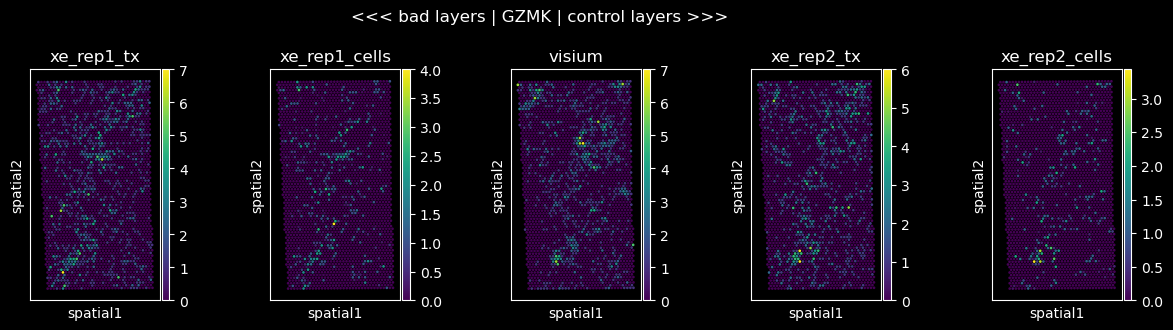

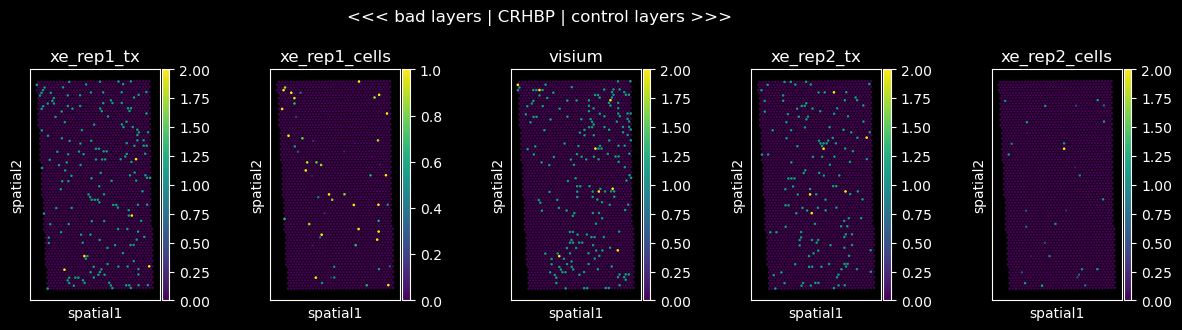

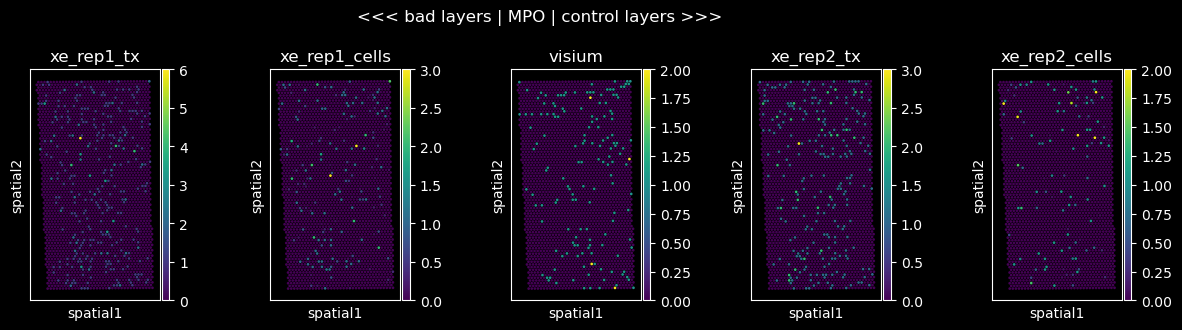

last row


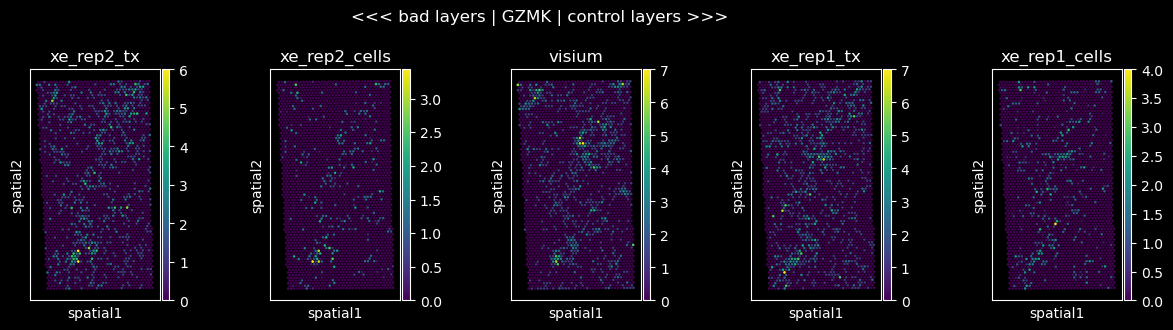

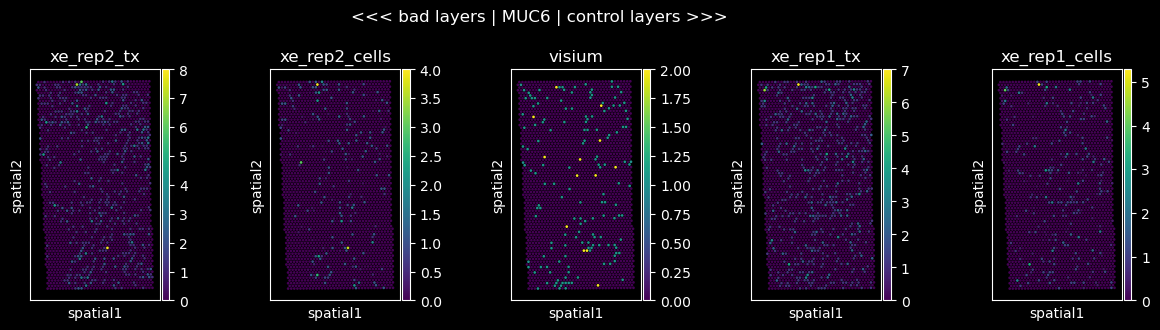

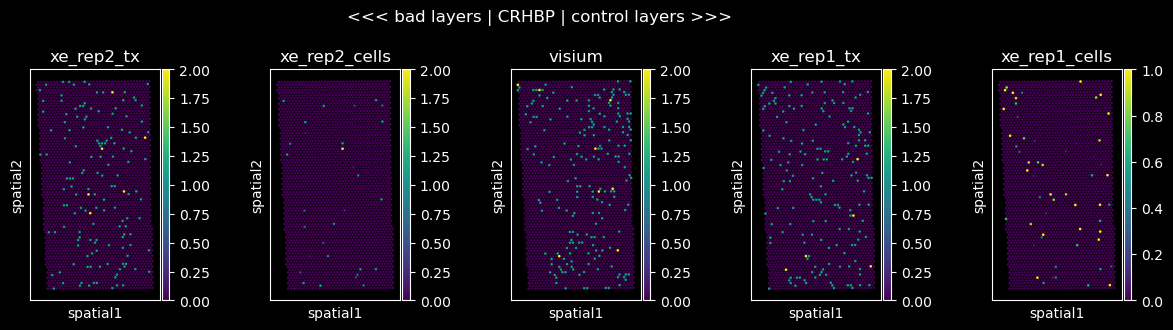

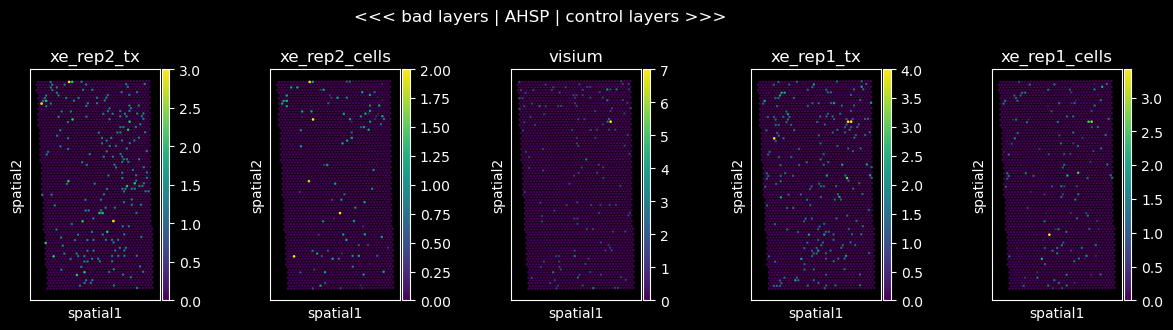

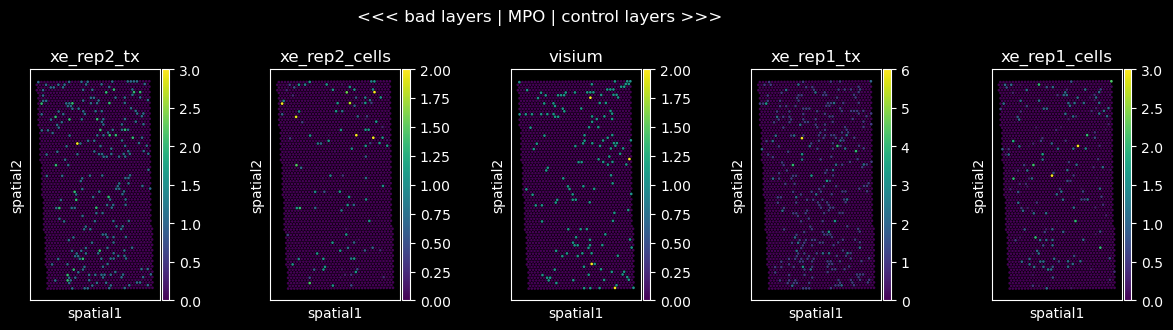

In [26]:
import matplotlib.pyplot as plt
import scanpy as sc

plt.style.use("dark_background")

visium_roi_sdata.table.layers["visium"] = visium_roi_sdata.table.X
for rep in ["rep1", "rep2"]:
    layers = [
        "xe_rep1_tx",
        "xe_rep1_cells",
        "xe_rep2_tx",
        "xe_rep2_cells",
        "visium",
    ]
    if rep == "rep1":
        genes = bad_genes2
        print("second last row")
    else:
        genes = bad_genes
        print("last row")
    bad_layers = [la for la in layers if rep in la] + ["visium"]
    control_layers = [la for la in layers if la not in bad_layers]

    for gene in genes:
        axes = plt.subplots(1, 5, figsize=(15, 3))[1].flatten()
        for i, ax in enumerate(axes):
            layer = (bad_layers + control_layers)[i]
            sc.pl.spatial(
                visium_roi_sdata.table,
                img_key=None,
                library_id=None,
                spot_size=160,
                color=gene,
                layer=layer,
                show=False,
                ax=ax,
                title=layer,
            )
        plt.suptitle(f"<<< bad layers | {gene} | control layers >>>", y=1.08)
    plt.show()

plt.style.use("default")

In [173]:
# to correct the visual appearance of the plot in the fig2, where we rotate the outline figure by 3.056 degrees
theta = -(3.056 / 180) * np.pi
rotation_matrix = np.array(
    [
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)],
    ]
)

In [174]:
spatial = np.array(
    [
        visium_roi_sdata["CytAssist_FFPE_Human_Breast_Cancer"].geometry.x,
        visium_roi_sdata["CytAssist_FFPE_Human_Breast_Cancer"].geometry.y,
    ]
).T
spatial = (rotation_matrix @ spatial.T).T
visium_roi_sdata.table.obsm["spatial"] = spatial

In [188]:
boundary = visium_roi_sdata["CytAssist_FFPE_Human_Breast_Cancer"].unary_union.convex_hull
box_x, box_y = boundary.exterior.xy
box_xy = np.vstack((box_x, box_y))
box_xy = rotation_matrix @ box_xy
box_x, box_y = box_xy

In [189]:
visium_roi_sdata.table.layers["xe_rep1_tx_log"] = np.log1p(visium_roi_sdata.table.layers["xe_rep1_tx"])
visium_roi_sdata.table.layers["xe_rep2_tx_log"] = np.log1p(visium_roi_sdata.table.layers["xe_rep2_tx"])

In [190]:
visium_roi_sdata.table.layers["xe_rep2_tx"].max()

1086.0

125
xe_rep2_cells vs xe_rep2_tx: 0.6195769246351133
visium vs xe_rep2_tx: 0.02515317277137225
visium vs xe_rep2_cells: 0.023592415967281614
xe_rep1_tx vs xe_rep2_tx: 0.039187146269330835
xe_rep1_tx vs xe_rep2_cells: 0.057186177266541655
xe_rep1_tx vs visium: -0.013706617713329873
xe_rep1_cells vs xe_rep2_tx: 0.010845847839336576
xe_rep1_cells vs xe_rep2_cells: 0.02036892656078635
xe_rep1_cells vs visium: 0.004743535763654372
xe_rep1_cells vs xe_rep1_tx: 0.6604752497929414
visium


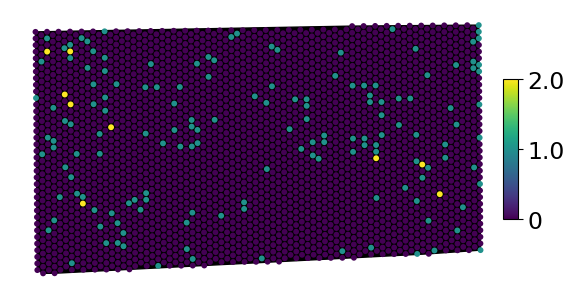

xe_rep1_tx


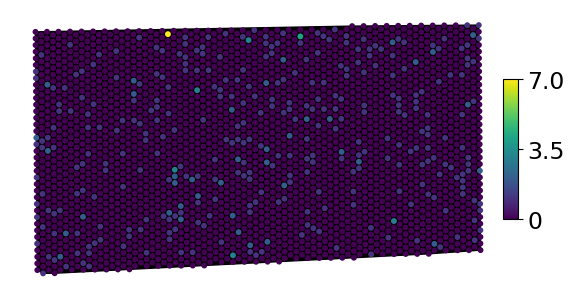

xe_rep2_tx


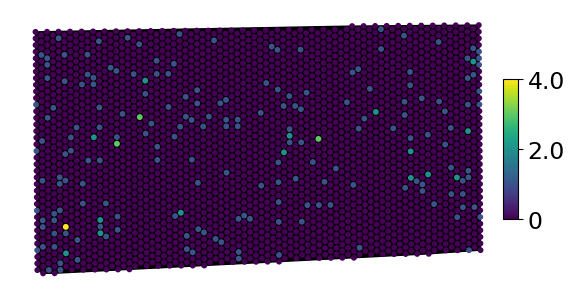

xe_rep1_cells


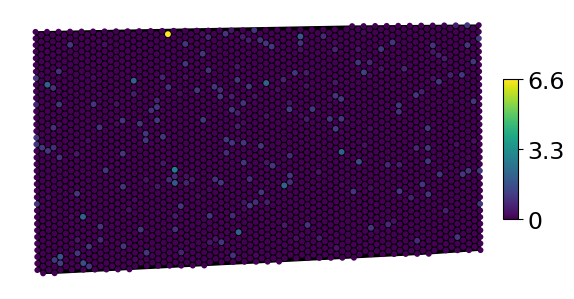

131
xe_rep2_cells vs xe_rep2_tx: 0.9958340426196207
visium vs xe_rep2_tx: 0.8763529471494411
visium vs xe_rep2_cells: 0.8808500618683669
xe_rep1_tx vs xe_rep2_tx: 0.9088888630605144
xe_rep1_tx vs xe_rep2_cells: 0.9100453697754519
xe_rep1_tx vs visium: 0.8766794197908656
xe_rep1_cells vs xe_rep2_tx: 0.9073549024294715
xe_rep1_cells vs xe_rep2_cells: 0.9110865134517047
xe_rep1_cells vs visium: 0.8870312605590609
xe_rep1_cells vs xe_rep1_tx: 0.9956233422609968
visium


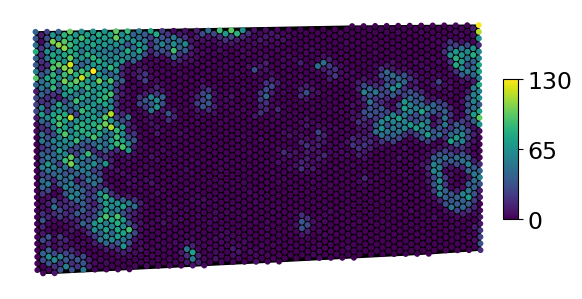

xe_rep1_tx


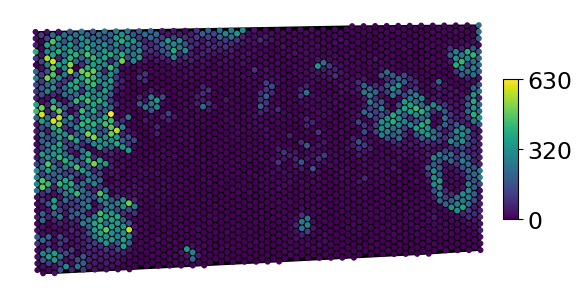

xe_rep2_tx


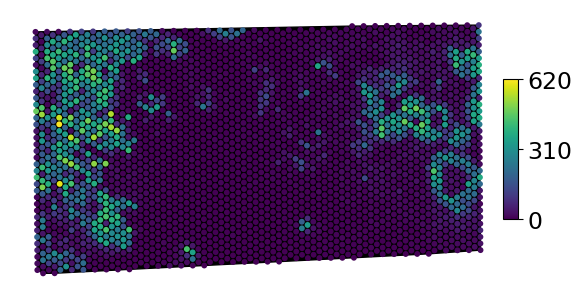

xe_rep1_cells


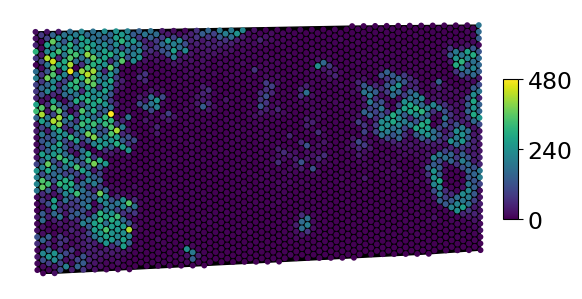

In [198]:
for custom_gene in ["UCP1", "FOXA1"]:
    gene_index = visium_roi_sdata.table.var_names.tolist().index(custom_gene)
    print(gene_index)

    v = {}
    for layer in ["xe_rep2_tx", "xe_rep2_cells", "visium", "xe_rep1_tx", "xe_rep1_cells"]:
        v[layer] = visium_roi_sdata.table.layers[layer][:, gene_index]

    v["visium"] = v["visium"].toarray().flatten()

    for l0 in v.keys():
        for l1 in v.keys():
            if l0 == l1:
                break
            corr, _ = pearsonr(v[l0], v[l1])
            print(f"{l0} vs {l1}: {corr}")

    import matplotlib.pyplot as plt
    import matplotlib.ticker as ticker
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes

    def one_sig_digits_large_numbers(x, pos):
        if x == 0:
            return "0"
        return f"{round(x, -int(np.floor(np.log10(abs(x))) - 1)):.0f}"
        # return "{:.1e}".format(x).replace("e+0", "e")

    def one_sig_digits_small_numbers(x, pos):
        if x == 0:
            return "0"
        return f"{x:.1f}"
        # return "{:.1e}".format(x).replace("e+0", "e")

    matplotlib.rcParams.update({"font.size": 17})
    for layer in ["visium", "xe_rep1_tx", "xe_rep2_tx", "xe_rep1_cells"]:
        print(layer)
        ax = plt.gca()
        ax.fill(box_x, box_y, c="k")
        sc.pl.spatial(
            visium_roi_sdata.table,
            img_key=None,
            library_id=None,
            spot_size=420,
            color=custom_gene,
            layer=layer,
            frameon=False,
            show=False,
            colorbar_loc=None,
            ax=ax,
            title="",
        )
        fig = plt.gcf()

        # Create a new inset axis for the colorbar
        cax = inset_axes(ax, width="3%", height="50%", loc="right", borderpad=-0.5)
        cbar = plt.colorbar(ax.collections[0], cax=cax)

        # Customize the colorbar ticks using LinearLocator
        cbar.locator = ticker.LinearLocator(numticks=3)
        cbar.update_ticks()

        # Format the ticks to show only 1 decimal digit
        # cbar.formatter = ticker.FormatStrFormatter('%.1f')
        # fast and ugly and dirty to get 2 significant digits for our two genes
        if custom_gene == "UCP1":
            cbar.formatter = ticker.FuncFormatter(one_sig_digits_small_numbers)
        if custom_gene == "FOXA1":
            cbar.formatter = ticker.FuncFormatter(one_sig_digits_large_numbers)
        # cbar.update_ticks()

        plt.show()

## Panel E

### Find cell types fractions from Xenium into polygonal ROIs

In [35]:
cell_types_categories = xe_rep1_roi_sdata.table.obs["celltype_major"].cat.categories.tolist()

rois_fractions = {}
for row in landmarks_sdata["rois"].iterrows():
    name = row[1][-1]
    cells_inside = cells_in_rois_sdata_rep1[f"Shapes in ROI '{name}'"]
    indices_rep1 = cells_inside.index.tolist()
    corresponding_rows_mask = xe_rep1_roi_sdata.table.obs["cell_id"].isin(indices_rep1)
    corresponding_rows = xe_rep1_roi_sdata.table[corresponding_rows_mask]
    cell_types = corresponding_rows.obs["celltype_major"]
    empty = pd.Series(index=cell_types_categories, data=np.zeros(len(cell_types_categories), dtype=float))
    counts = cell_types.value_counts()
    empty.loc[counts.index] = counts
    rois_fractions[name] = empty
df1_rois = pd.DataFrame(rois_fractions).transpose()

In [36]:
cell_types_categories = xe_rep2_roi_sdata.table.obs["celltype_major"].cat.categories.tolist()

rois_fractions = {}
for row in landmarks_sdata["rois"].iterrows():
    name = row[1][-1]
    cells_inside = cells_in_rois_sdata_rep2[f"Shapes in ROI '{name}'"]
    indices_rep2 = cells_inside.index.tolist()
    corresponding_rows_mask = xe_rep2_roi_sdata.table.obs["cell_id"].isin(indices_rep2)
    corresponding_rows = xe_rep2_roi_sdata.table[corresponding_rows_mask]
    cell_types = corresponding_rows.obs["celltype_major"]
    empty = pd.Series(index=cell_types_categories, data=np.zeros(len(cell_types_categories), dtype=float))
    counts = cell_types.value_counts()
    empty.loc[counts.index] = counts
    rois_fractions[name] = empty
df2_rois = pd.DataFrame(rois_fractions).transpose()

In [37]:
df1_rois

B-cells    CAFs  Cancer Epithelial  Endothelial  Myeloid  \
Invasive                91.0  1516.0            12592.0       1526.0   1963.0   
Immune infiltration    426.0   364.0                0.0        138.0    472.0   
DCIS                    10.0   193.0             4756.0        171.0    529.0   
Duct ectasia            10.0    28.0                4.0          2.0    191.0   

                     Normal Epithelial    PVL  Plasmablasts  T-cells  
Invasive                        1677.0  292.0         211.0   2418.0  
Immune infiltration                1.0   25.0         127.0   1170.0  
DCIS                            2211.0   66.0          12.0    211.0  
Duct ectasia                     534.0    0.0           0.0     61.0

In [38]:
df2_rois

B-cells    CAFs  Cancer Epithelial  Endothelial  Myeloid  \
Invasive               124.0  1161.0            13578.0       1575.0   1833.0   
Immune infiltration    491.0   315.0                0.0        121.0    471.0   
DCIS                     5.0   187.0             4912.0        174.0    487.0   
Duct ectasia             3.0    25.0                4.0         11.0    200.0   

                     Normal Epithelial    PVL  Plasmablasts  T-cells  
Invasive                         917.0  343.0         222.0   2398.0  
Immune infiltration                0.0   27.0         124.0   1216.0  
DCIS                            1988.0   58.0          12.0    200.0  
Duct ectasia                     541.0    4.0           3.0     73.0

### Find cell types fractions from Xenium into Visium clonal ROIs

In [39]:
from spatialdata import concatenate
from tqdm import tqdm


def spatial_query_shapes_by_polygons(sdata: SpatialData, polygons: list[Polygon], target_coordinate_system: str):
    sdatas = []
    for polygon in tqdm(polygons):
        try:
            queried_sdata = spatial_query_shapes_by_polygon(
                sdata=sdata, polygon=polygon, target_coordinate_system=target_coordinate_system
            )
            sdatas.append(queried_sdata)
        except ValueError as e:
            if str(e) != "we expect at least one shape":
                raise e
            print("skipping", end="")
    print("len(polygons) =", len(polygons))
    print("len(sdatas) =", len(sdatas))
    geodataframe_pieces = {}

    for sdata in sdatas:
        for shapes_name, shapes in sdata.shapes.items():
            if shapes_name not in geodataframe_pieces:
                geodataframe_pieces[shapes_name] = []
            geodataframe_pieces[shapes_name].append(shapes)

    geodataframes = {}
    for k, v in geodataframe_pieces.items():
        geodataframes[k] = pd.concat(v)
    return SpatialData(shapes=geodataframes, table=sdatas[0].table)


from geopandas import GeoSeries

visium_circles = visium_roi_sdata.shapes["CytAssist_FFPE_Human_Breast_Cancer"]

In [40]:
clone_sdatas_rep1 = {}

for clone in ["1", "2", "3"]:
    clone_rows = visium_roi_sdata.table[visium_roi_sdata.table.obs["clone"] == clone]
    merged = clone_rows.obs.merge(visium_circles, how="left", left_on="spot_id", right_index=True)
    clone_polygons = GeoSeries(merged.geometry).buffer(visium_circles.radius.iloc[0], 128).tolist()
    sdata = spatial_query_shapes_by_polygons(
        SpatialData(shapes={"cell_circles": xe_rep1_roi_sdata["cell_boundaries"]}, table=xe_rep1_roi_sdata.table),
        clone_polygons,
        "aligned",
    )
    clone_sdatas_rep1[clone] = sdata

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 369/369 [04:30<00:00,  1.37it/s]


len(polygons) = 369
len(sdatas) = 369


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 212/212 [02:33<00:00,  1.38it/s]


len(polygons) = 212
len(sdatas) = 212


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 289/289 [03:29<00:00,  1.38it/s]

len(polygons) = 289
len(sdatas) = 289


In [41]:
clone_sdatas_rep2 = {}

for clone in ["1", "2", "3"]:
    clone_rows = visium_roi_sdata.table[visium_roi_sdata.table.obs["clone"] == clone]
    merged = clone_rows.obs.merge(visium_circles, how="left", left_on="spot_id", right_index=True)
    clone_polygons = GeoSeries(merged.geometry).buffer(visium_circles.radius.iloc[0], 128).tolist()
    sdata = spatial_query_shapes_by_polygons(
        SpatialData(shapes={"cell_circles": xe_rep2_roi_sdata["cell_boundaries"]}, table=xe_rep2_roi_sdata.table),
        clone_polygons,
        "aligned",
    )
    clone_sdatas_rep2[clone] = sdata

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 369/369 [04:26<00:00,  1.39it/s]


len(polygons) = 369
len(sdatas) = 369


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 212/212 [02:32<00:00,  1.39it/s]


len(polygons) = 212
len(sdatas) = 212


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 289/289 [03:28<00:00,  1.39it/s]

len(polygons) = 289
len(sdatas) = 289


In [42]:
cell_types_categories = xe_rep1_roi_sdata.table.obs["celltype_major"].cat.categories.tolist()

clones_fractions = {}
for name, sdata in clone_sdatas_rep1.items():
    indices_rep1 = sdata.shapes["cell_circles"].index.tolist()
    corresponding_rows_mask = xe_rep1_roi_sdata.table.obs["cell_id"].isin(indices_rep1)
    corresponding_rows = xe_rep1_roi_sdata.table[corresponding_rows_mask]
    cell_types = corresponding_rows.obs["celltype_major"]
    empty = pd.Series(index=cell_types_categories, data=np.zeros(len(cell_types_categories), dtype=float))
    counts = cell_types.value_counts()
    empty.loc[counts.index] = counts
    clones_fractions[f"Clone {name}"] = empty

df1_clones = pd.DataFrame(clones_fractions).transpose()

In [43]:
cell_types_categories = xe_rep2_roi_sdata.table.obs["celltype_major"].cat.categories.tolist()

clones_fractions = {}
for name, sdata in clone_sdatas_rep2.items():
    indices_rep2 = sdata.shapes["cell_circles"].index.tolist()
    corresponding_rows_mask = xe_rep2_roi_sdata.table.obs["cell_id"].isin(indices_rep2)
    corresponding_rows = xe_rep2_roi_sdata.table[corresponding_rows_mask]
    cell_types = corresponding_rows.obs["celltype_major"]
    empty = pd.Series(index=cell_types_categories, data=np.zeros(len(cell_types_categories), dtype=float))
    counts = cell_types.value_counts()
    empty.loc[counts.index] = counts
    clones_fractions[f"Clone {name}"] = empty

df2_clones = pd.DataFrame(clones_fractions).transpose()

In [44]:
df1_clones

B-cells   CAFs  Cancer Epithelial  Endothelial  Myeloid  \
Clone 1     22.0  681.0             8493.0        707.0    878.0   
Clone 2     65.0  734.0             1907.0        516.0    827.0   
Clone 3     20.0  950.0             5017.0        391.0    717.0   

         Normal Epithelial    PVL  Plasmablasts  T-cells  
Clone 1             1041.0  109.0          46.0    733.0  
Clone 2             1142.0  138.0         111.0   1143.0  
Clone 3             2747.0   95.0          98.0    490.0

In [45]:
df2_clones

B-cells   CAFs  Cancer Epithelial  Endothelial  Myeloid  \
Clone 1     25.0  556.0             9203.0        732.0    821.0   
Clone 2     78.0  627.0             2132.0        519.0    737.0   
Clone 3     20.0  843.0             5246.0        418.0    657.0   

         Normal Epithelial    PVL  Plasmablasts  T-cells  
Clone 1              527.0  122.0          57.0    793.0  
Clone 2              919.0  190.0         135.0   1068.0  
Clone 3             2510.0  124.0          87.0    481.0

### Find cell types fractions for the Visium data

In [46]:
VISIUM_CELL2LOCATION_PATH = os.path.join(GENERATED_DATA_PATH, "visium_annotated_cell2location.h5ad")

cell2location_adata = sc.read_h5ad(VISIUM_CELL2LOCATION_PATH)
cell2location_adata

/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 2829 × 270
    obs: 'in_tissue', 'array_row', 'array_col', 'spot_id', 'dataset', 'ROI', 'n_counts', '_indices', '_scvi_batch', '_scvi_labels', 'B-cells', 'CAFs', 'Cancer Epithelial', 'Endothelial', 'Myeloid', 'Normal Epithelial', 'PVL', 'Plasmablasts', 'T-cells'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'mod', 'spatial', 'spatialdata_attrs', 'wilcoxon'
    obsm: 'means_cell_abundance_w_sf', 'q05_cell_abundance_w_sf', 'q95_cell_abundance_w_sf', 'stds_cell_abundance_w_sf', 'xe_rep1_celltype_major', 'xe_rep1_celltype_minor', 'xe_rep2_celltype_major', 'xe_rep2_celltype_minor'
    layers: 'xe_rep1_tx', 'xe_rep2_tx'

In [47]:
obs_names = cell2location_adata.obs["spot_id"].to_numpy()

In [48]:
cell_types_categories = xe_rep1_roi_sdata.table.obs["celltype_major"].cat.categories.tolist()
columns = [cell2location_adata.obs[c] for c in cell_types_categories]
x = np.stack(columns).T
print(x.shape)
obs = pd.DataFrame(index=obs_names)
var = pd.DataFrame(index=cell_types_categories)
visium_celltypes_adata = AnnData(x, obs=obs, var=var)

(2829, 9)


/tmp/ipykernel_3215/3108085225.py:7: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  visium_celltypes_adata = AnnData(x, obs=obs, var=var)
/Users/macbook/miniconda3/envs/ome/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [50]:
import pandas as pd
from spatialdata.models import TableModel

visium_circles_in_rois_sdata = get_shapes_in_rois_sdata(
    sdata=visium_roi_sdata,
    shapes_name="CytAssist_FFPE_Human_Breast_Cancer",
    rois=landmarks_sdata["rois"],
    instance_key="spot_id",
)
visium_circles_in_rois_sdata

/tmp/ipykernel_3215/532282607.py:26: UserWarning: Converting `region_key: region` to categorical dtype.
  TableModel.parse(filtered_table, region=region_name, region_key="region", instance_key=instance_key)
/tmp/ipykernel_3215/532282607.py:26: UserWarning: Converting `region_key: region` to categorical dtype.
  TableModel.parse(filtered_table, region=region_name, region_key="region", instance_key=instance_key)
/tmp/ipykernel_3215/532282607.py:26: UserWarning: Converting `region_key: region` to categorical dtype.
  TableModel.parse(filtered_table, region=region_name, region_key="region", instance_key=instance_key)
/tmp/ipykernel_3215/532282607.py:26: UserWarning: Converting `region_key: region` to categorical dtype.
  TableModel.parse(filtered_table, region=region_name, region_key="region", instance_key=instance_key)


SpatialData object with:
├── Shapes
│     ├── "Shapes in ROI 'DCIS'": GeoDataFrame shape: (146, 2) (2D shapes)
│     ├── "Shapes in ROI 'Duct ectasia'": GeoDataFrame shape: (13, 2) (2D shapes)
│     ├── "Shapes in ROI 'Immune infiltration'": GeoDataFrame shape: (24, 2) (2D shapes)
│     └── "Shapes in ROI 'Invasive'": GeoDataFrame shape: (435, 2) (2D shapes)
└── Table
      └── AnnData object with n_obs × n_vars = 618 × 307
    obs: 'in_tissue', 'array_row', 'array_col', 'spot_id', 'region', 'dataset', 'clone'
    uns: 'spatialdata_attrs'
    obsm: 'spatial', 'xe_rep1_celltype_major', 'xe_rep1_celltype_minor', 'xe_rep2_celltype_major', 'xe_rep2_celltype_minor'
    layers: 'xe_rep1_cells', 'xe_rep1_tx', 'xe_rep2_cells', 'xe_rep2_tx', 'visium', 'xe_rep1_tx_log', 'xe_rep2_tx_log': AnnData (618, 307)
with coordinate systems:
▸ 'aligned', with elements:
        Shapes in ROI 'DCIS' (Shapes), Shapes in ROI 'Duct ectasia' (Shapes), Shapes in ROI 'Immune infiltration' (Shapes), Shapes in ROI '

In [51]:
cell_types_categories = xe_rep1_roi_sdata.table.obs["celltype_major"].cat.categories.tolist()

rois_fractions = {}
for row in landmarks_sdata["rois"].iterrows():
    name = row[1][-1]
    circles_inside = visium_circles_in_rois_sdata[f"Shapes in ROI '{name}'"]
    indices_circles = circles_inside.index.tolist()
    corresponding_rows_mask = visium_celltypes_adata.obs.index.astype(int).isin(indices_circles)
    corresponding_rows = visium_celltypes_adata[corresponding_rows_mask]

    counts = np.sum(corresponding_rows.X, axis=0).copy()
    empty = pd.Series(index=cell_types_categories, data=counts, dtype=float)
    rois_fractions[name] = empty
    # rois_fractions[name] = corresponding_rows
# rois_fractions
df3_rois = pd.DataFrame(rois_fractions).transpose()
df3_rois

B-cells       CAFs  Cancer Epithelial  Endothelial  \
Invasive              9.435946  27.687658        4980.297363    52.937027   
Immune infiltration  13.207269   3.389608           0.177029     0.683461   
DCIS                  0.534150   4.138905        2258.740967     2.631811   
Duct ectasia          0.833282   0.723009           1.193322     0.194306   

                       Myeloid  Normal Epithelial       PVL  Plasmablasts  \
Invasive             27.697487         155.509583  9.235755      8.938135   
Immune infiltration   4.676432           0.334023  0.126233      1.443351   
DCIS                 19.301350         106.329857  1.343578      2.084949   
Duct ectasia         27.008394          14.080745  0.117122      0.172584   

                       T-cells  
Invasive             59.511402  
Immune infiltration  17.610943  
DCIS                  3.627190  
Duct ectasia          1.828164

In [52]:
clones_fractions = {}

for clone in ["1", "2", "3"]:
    clone_rows = visium_roi_sdata.table[visium_roi_sdata.table.obs["clone"] == clone]
    circle_id = clone_rows.obs["spot_id"].tolist()
    mask = visium_celltypes_adata.obs.index.astype(int).isin(circle_id)
    corresponding_rows = visium_celltypes_adata[mask]

    counts = np.sum(corresponding_rows.X, axis=0).copy()
    empty = pd.Series(index=cell_types_categories, data=counts, dtype=float)
    clones_fractions[f"Clone {clone}"] = empty

df3_clones = pd.DataFrame(clones_fractions).transpose()
df3_clones

B-cells       CAFs  Cancer Epithelial  Endothelial    Myeloid  \
Clone 1  2.942353  15.670433        5378.034668    37.768486  14.270922   
Clone 2  7.453361  29.139797        1157.498169    27.041031  26.881823   
Clone 3  2.522369  23.611021        3742.106201    10.839885  23.815939   

         Normal Epithelial       PVL  Plasmablasts    T-cells  
Clone 1         172.326828  5.335557      2.978759  25.137407  
Clone 2          55.948845  7.638354      7.684133  51.599129  
Clone 3         201.607132  4.931158     10.238660  17.414379

### Plot the fractions

In [53]:
df1 = pd.concat([df1_rois, df1_clones])
df2 = pd.concat([df2_rois, df2_clones])
df3 = pd.concat([df3_rois, df3_clones])

In [54]:
df1

B-cells    CAFs  Cancer Epithelial  Endothelial  Myeloid  \
Invasive                91.0  1516.0            12592.0       1526.0   1963.0   
Immune infiltration    426.0   364.0                0.0        138.0    472.0   
DCIS                    10.0   193.0             4756.0        171.0    529.0   
Duct ectasia            10.0    28.0                4.0          2.0    191.0   
Clone 1                 22.0   681.0             8493.0        707.0    878.0   
Clone 2                 65.0   734.0             1907.0        516.0    827.0   
Clone 3                 20.0   950.0             5017.0        391.0    717.0   

                     Normal Epithelial    PVL  Plasmablasts  T-cells  
Invasive                        1677.0  292.0         211.0   2418.0  
Immune infiltration                1.0   25.0         127.0   1170.0  
DCIS                            2211.0   66.0          12.0    211.0  
Duct ectasia                     534.0    0.0           0.0     61.0  
Clone 1                         1041.0  109.0          46.0    733.0  
Clone 2                         1142.0  138.0         111.0   1143.0  
Clone 3                         2747.0   95.0          98.0    490.0

In [55]:
df2

B-cells    CAFs  Cancer Epithelial  Endothelial  Myeloid  \
Invasive               124.0  1161.0            13578.0       1575.0   1833.0   
Immune infiltration    491.0   315.0                0.0        121.0    471.0   
DCIS                     5.0   187.0             4912.0        174.0    487.0   
Duct ectasia             3.0    25.0                4.0         11.0    200.0   
Clone 1                 25.0   556.0             9203.0        732.0    821.0   
Clone 2                 78.0   627.0             2132.0        519.0    737.0   
Clone 3                 20.0   843.0             5246.0        418.0    657.0   

                     Normal Epithelial    PVL  Plasmablasts  T-cells  
Invasive                         917.0  343.0         222.0   2398.0  
Immune infiltration                0.0   27.0         124.0   1216.0  
DCIS                            1988.0   58.0          12.0    200.0  
Duct ectasia                     541.0    4.0           3.0     73.0  
Clone 1                          527.0  122.0          57.0    793.0  
Clone 2                          919.0  190.0         135.0   1068.0  
Clone 3                         2510.0  124.0          87.0    481.0

In [56]:
df3

B-cells       CAFs  Cancer Epithelial  Endothelial  \
Invasive              9.435946  27.687658        4980.297363    52.937027   
Immune infiltration  13.207269   3.389608           0.177029     0.683461   
DCIS                  0.534150   4.138905        2258.740967     2.631811   
Duct ectasia          0.833282   0.723009           1.193322     0.194306   
Clone 1               2.942353  15.670433        5378.034668    37.768486   
Clone 2               7.453361  29.139797        1157.498169    27.041031   
Clone 3               2.522369  23.611021        3742.106201    10.839885   

                       Myeloid  Normal Epithelial       PVL  Plasmablasts  \
Invasive             27.697487         155.509583  9.235755      8.938135   
Immune infiltration   4.676432           0.334023  0.126233      1.443351   
DCIS                 19.301350         106.329857  1.343578      2.084949   
Duct ectasia         27.008394          14.080745  0.117122      0.172584   
Clone 1              14.270922         172.326828  5.335557      2.978759   
Clone 2              26.881823          55.948845  7.638354      7.684133   
Clone 3              23.815939         201.607132  4.931158     10.238660   

                       T-cells  
Invasive             59.511402  
Immune infiltration  17.610943  
DCIS                  3.627190  
Duct ectasia          1.828164  
Clone 1              25.137407  
Clone 2              51.599129  
Clone 3              17.414379

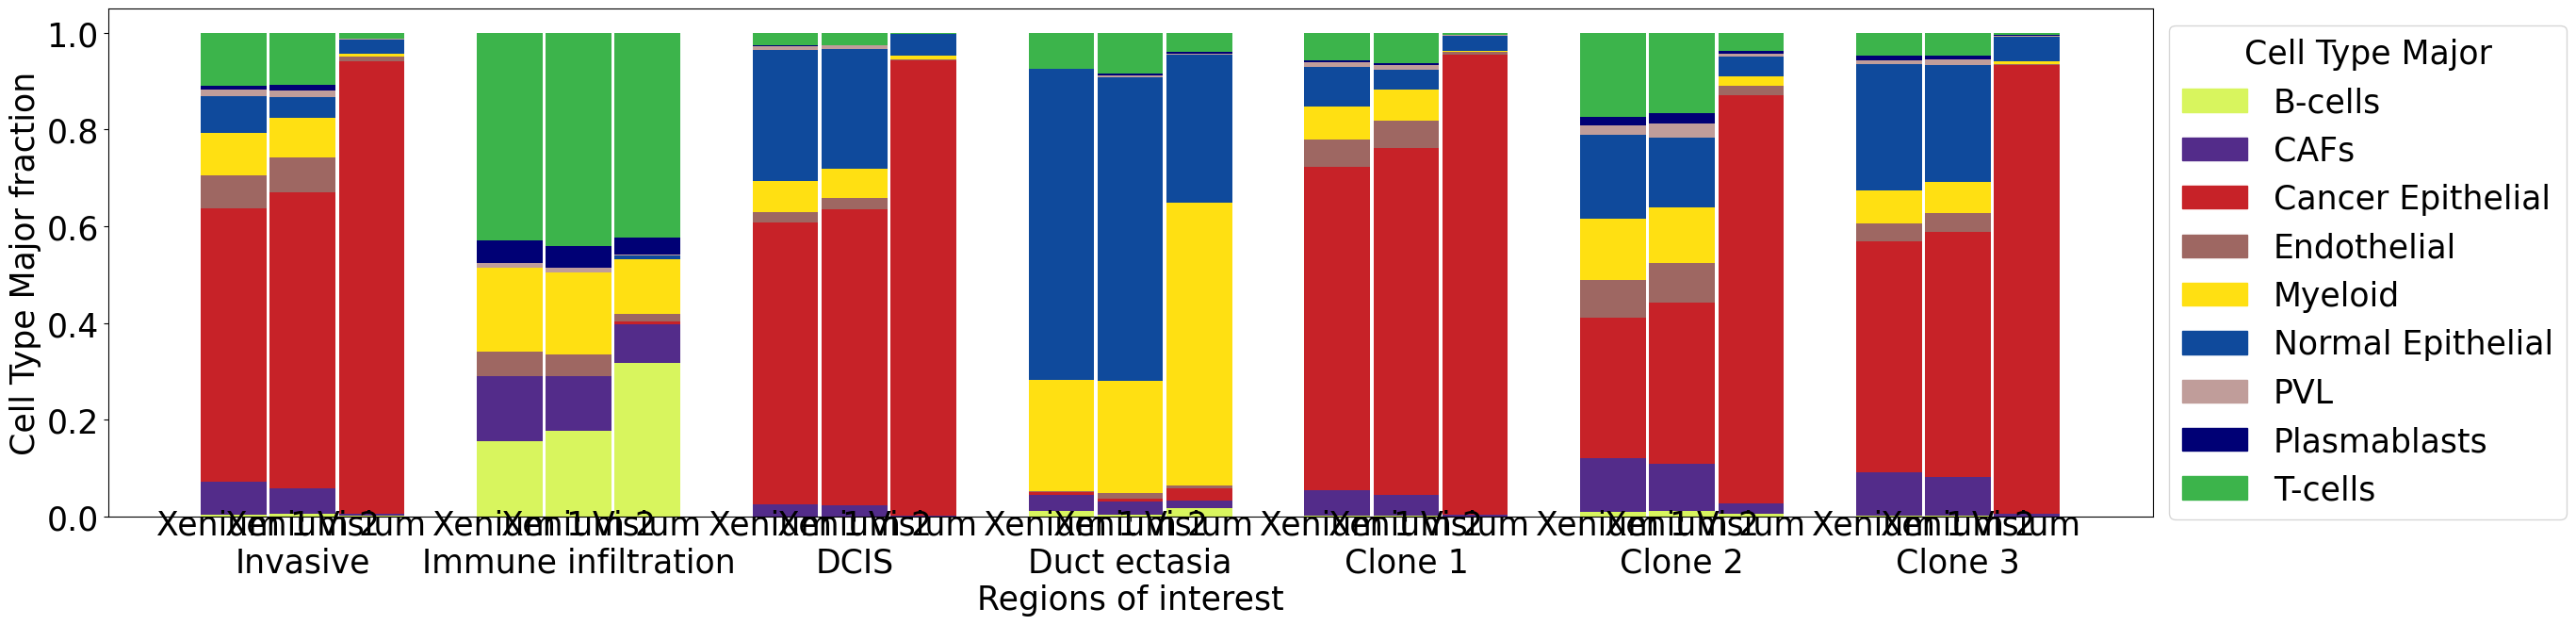

In [57]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Normalize the data by row to make each bar's height the same
df1 = df1.div(df1.sum(axis=1), axis=0)
df2 = df2.div(df2.sum(axis=1), axis=0)
df3 = df3.div(df3.sum(axis=1), axis=0)

# Define the custom colors
cell_types_categories = xe_rep1_roi_sdata.table.obs["celltype_major"].cat.categories.tolist()
colors = xe_rep1_roi_sdata.table.uns["celltype_major_colors"]
regions_names = df1.index.tolist()
# replace last df with visium one
dataframes = [df1, df2, df3]
dataframes_names = ["Xenium 1", "Xenium 2", "Visium"]

# Set the width of a bar
bar_width = 0.35

# Positions of the bars on the x-axis
ind = np.arange(len(df1.index))

# Create the grouped bar plot using Pandas
fig, ax = plt.subplots(figsize=(28, 7))

cumulative_bars = [np.zeros(len(regions_names)) for _ in range(len(dataframes))]
for i, cell_type in enumerate(cell_types_categories):
    bar_width = 0.25

    for j, df in enumerate(dataframes):
        previous = cumulative_bars[j]
        x_values = bar_width * (np.arange(len(regions_names)) * (len(dataframes) + 1) + (len(dataframes) + j))
        y_values = df.loc[:, cell_type].to_numpy()
        ax.bar(x_values, y_values, bar_width * 0.95, color=colors[i], bottom=previous)
        cumulative_bars[j] += y_values

        # Add the labels below each bar
        if i == 0:
            for k, x in enumerate(x_values):
                ax.text(x, -0.05, dataframes_names[j], ha="center", va="bottom", rotation=0)


# Customize the plot
ax.set_xticks(bar_width * (np.arange(len(regions_names)) * (len(dataframes) + 1) + len(dataframes) / 2 + 2.5))
xticklabels = ax.set_xticklabels(regions_names, rotation=0)
for label in xticklabels:
    label.set_y(-0.04)  # Adjust the y value to position the labels lower

ax.set_xlabel("Regions of interest")
ax.set_ylabel("Cell Type Major fraction")

# Create custom patches for the legend
legend_patches = [mpatches.Patch(color=color, label=name) for color, name in zip(colors, cell_types_categories)]

# Add the custom legend to the plot
ax.legend(handles=legend_patches, title="Cell Type Major", bbox_to_anchor=(1, 1))

plt.show()

Same plot, but in horizontal layout (better)

In [58]:
df1_copy = df1.copy()
df2_copy = df2.copy()
df3_copy = df3.copy()

df1 = df1.loc[["Immune infiltration", "Clone 1"], :]
df2 = df2.loc[["Immune infiltration", "Clone 1"], :]
df3 = df3.loc[["Immune infiltration", "Clone 1"], :]

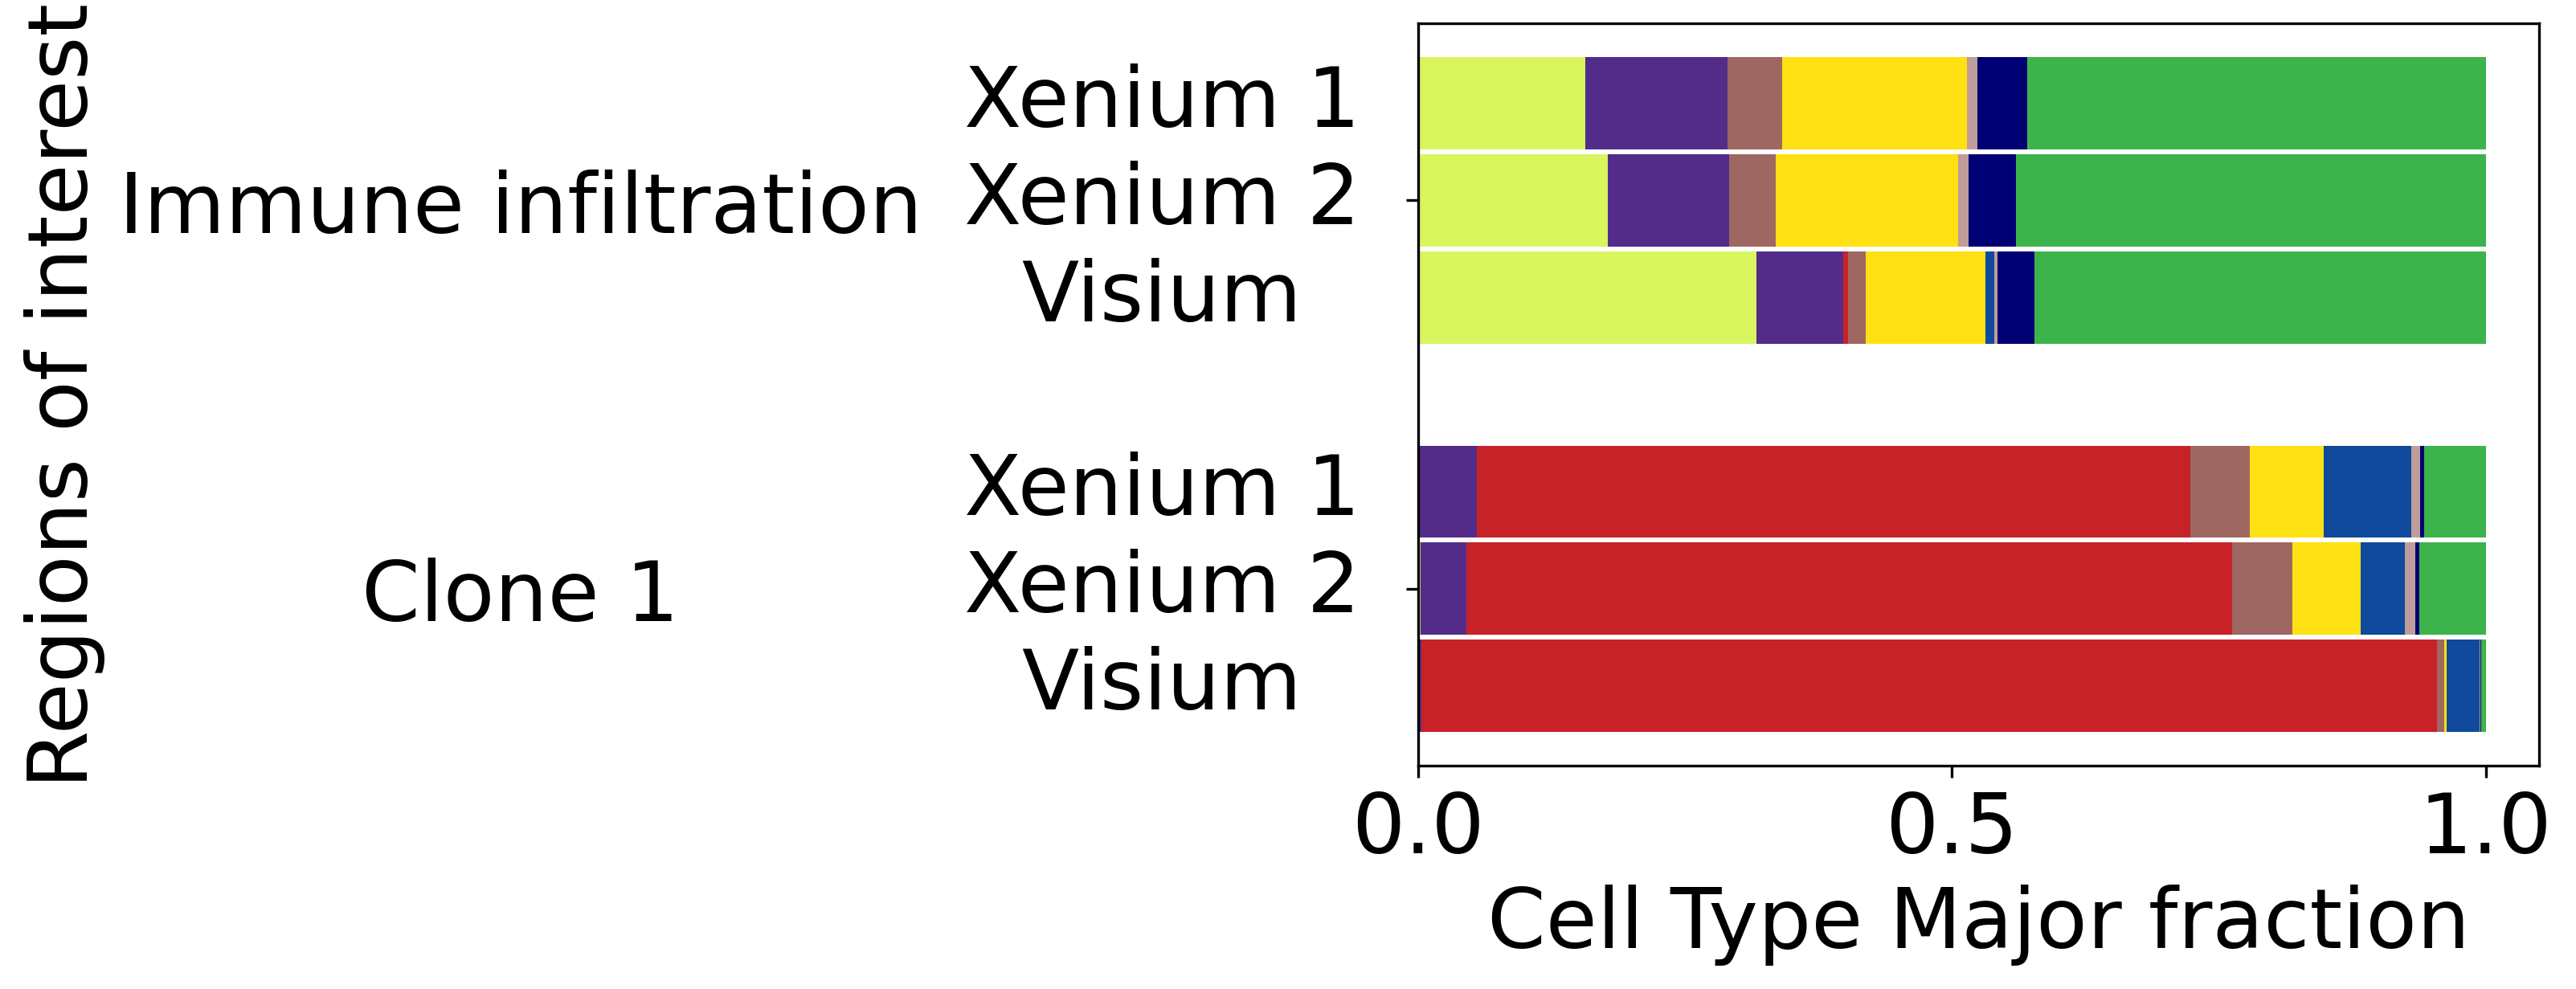

In [59]:
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Normalize the data by row to make each bar's height the same
df1 = df1.div(df1.sum(axis=1), axis=0)
df2 = df2.div(df2.sum(axis=1), axis=0)
df3 = df3.div(df3.sum(axis=1), axis=0)

# Define the custom colors
cell_types_categories = xe_rep1_roi_sdata.table.obs["celltype_major"].cat.categories.tolist()
colors = xe_rep1_roi_sdata.table.uns["celltype_major_colors"]
regions_names = df1.index.tolist()
# replace last df with visium one
dataframes = [df1, df2, df3]
dataframes_names = ["Xenium 1", "Xenium 2", "Visium"]

# Set the width of a bar
bar_width = 0.35

# Positions of the bars on the y-axis
ind = np.arange(len(df1.index))

# Create the grouped bar plot using Pandas
# fig, ax = plt.subplots(figsize=(10, 7))
matplotlib.rcParams.update({"font.size": 25})
fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
cumulative_bars = [np.zeros(len(regions_names)) for _ in range(len(dataframes))]
for i, cell_type in enumerate(cell_types_categories):
    bar_width = 0.25

    for j, df in enumerate(dataframes):
        previous = cumulative_bars[j]
        y_values = bar_width * (np.arange(len(regions_names)) * (len(dataframes) + 1) + (len(dataframes) + j))
        x_values = df.loc[:, cell_type].to_numpy()
        ax.barh(y_values, x_values, bar_width * 0.95, color=colors[i], left=previous)
        cumulative_bars[j] += x_values

        # Add the labels below each bar
        if i == 0:
            for k, y in enumerate(y_values):
                ax.text(-0.24, y, dataframes_names[j], ha="center", va="center", rotation=0)


# Customize the plot
ax.set_yticks(bar_width * (np.arange(len(regions_names)) * (len(dataframes) + 1) + len(dataframes) / 2 + 2.5))
yticklabels = ax.set_yticklabels(regions_names, rotation=0, ha="center")
for label in yticklabels:
    label.set_x(-0.78)  # Adjust the x value to position the labels lower

ax.set_ylabel("Regions of interest")
ax.set_xlabel("Cell Type Major fraction")
ax.invert_yaxis()

# Create custom patches for the legend
legend_patches = [mpatches.Patch(color=color, label=name) for color, name in zip(colors, cell_types_categories)]

# Add the custom legend to the plot
# ax.legend(handles=legend_patches, title='Cell Type Major', bbox_to_anchor=(1, 1), ncol=9)
plt.show()

## Computing the Pearson correlation between cell-types

In [250]:
visium_celltypes_adata

AnnData object with n_obs × n_vars = 2829 × 9

In [251]:
spot_id_visium_cell2location = obs_names

In [252]:
spot_id_visium_sdata = visium_roi_sdata.table.obs.spot_id.to_numpy()

In [253]:
# the Visium cell2location AnnData object has a strict superset of spot_id compared to the ones present in the visium_roi_sdata table object
assert np.array_equal(np.intersect1d(spot_id_visium_cell2location, spot_id_visium_sdata), spot_id_visium_sdata)

visium_celltypes_adata_roi = visium_celltypes_adata[spot_id_visium_sdata.astype(str)]

In [258]:
a0 = visium_celltypes_adata_roi.X.copy()

In [255]:
a1 = visium_roi_sdata.table.obsm["xe_rep1_celltype_major"]

In [256]:
a2 = visium_roi_sdata.table.obsm["xe_rep2_celltype_major"]

In [263]:
print(a0.shape)

(2775, 9)


### Pearson's R for cell types agreement between Xenium rep1 and Xenium rep2

In [293]:
# one correlation per Visium circle, each correlation is computed between two 9 dimensional vectors
correlations_12 = compute_correlations(a1, a2, axis=0)

In [294]:
print(correlations_12.shape)

(2775,)


In [295]:
print(np.sum(np.isnan(correlations_12)))

46


In [296]:
np.nanmedian(correlations_12)

0.805898608519146

In [297]:
np.nanmean(correlations_12)

0.6841987129540205

### Pearson's R for cell types agreement between Visium and Xenium rep1

In [271]:
correlations_01 = compute_correlations(a0, a1, axis=0)

In [285]:
print(correlations_01.shape)

(2775,)


In [273]:
print(np.sum(np.isnan(correlations_01)))

26


In [275]:
np.nanmedian(correlations_01)

0.7043965633614588

In [277]:
np.nanmean(correlations_01)

0.6073485507202422

### Pearson's R for cell types agreement between Visium and Xenium rep2

In [279]:
correlations_02 = compute_correlations(a0, a2, axis=0)

In [286]:
print(correlations_02.shape)

(2775,)


In [280]:
np.nanmedian(correlations_02)

0.7204759719961114

In [281]:
np.nanmean(correlations_02)

0.6158423457587308